# Pulling Crime Data for Hartford

In May of 2021 the City of Hartford Police Department updated their Computer Aided Dispatch(CAD) system and in the process made their historical data available via the [City of Hartford API, powered by Socrata](https://dev.socrata.com/foundry/data.hartford.gov/889t-nwfu). This historic dataset reflects reported incidents of crime (with the exception of sexual assaults, which are excluded by statute) that occurred in the City of Hartford from January 1, 2005 to May 18, 2021. These incidents are based on crimes verified by the Hartford Police Department's Crime Analysis Division.

## About the Data

This historic dataset reflects reported incidents of crime (with the exception of sexual assaults, which are excluded by statute) that occurred in the City of Hartford from January 1, 2005 to May 18, 2021. These incidents are based on crimes verified by the Hartford Police Department's Crime Analysis Division.

In total the data set contain 708,985 observations.

## Pull in the Data

The `889t-nwfu` dataset published to data.hartford.gov. All communication with the API is done through HTTPS, and errors are communicated through HTTP response codes. TIf you just want to grab the API endpoint and go, you'll find it below:

```
https://data.hartford.gov/resource/889t-nwfu.json 
```

Documentation for working with the SODA API can be found [here](https://dev.socrata.com/consumers/getting-started.html).

For filtering, you can pass a range of parameters via the URL:

```
https://data.hartford.gov/resource/889t-nwfu.json?case_number=4058052
```

Let's pull the data using this endpoint, some added parameters, and dictionary comprehension to map a function over a range of values.

In [1]:
# Load required libraries:
import requests
import pandas as pd
from pandas import DataFrame
import os

# Declare an endpoint:
wanted_url = "https://data.hartford.gov/resource/889t-nwfu.json?$where=date%20between%20%272015-01-01%27%20and%20%272020-12-31%27%20limit%20800000"

# Pull and transform the JSON into 
hartford = requests.get(wanted_url).json()

We have to extract the latitude and longitude from a nested dictionary:

In [2]:
def parse_entries(nested_dict: dict, nested_key: str) -> pd.DataFrame:
    out = {}
    out = {key: value for key, value in nested_dict.items() if key != nested_key}
    out['latitude'] = nested_dict['geom']['latitude']
    out['longitude'] = nested_dict['geom']['longitude']
    return(out)

hartford_clean = [parse_entries(x, 'geom') for x in hartford]
hartford_df = DataFrame.from_dict(hartford_clean)

Group and split into list of yearly dataframes:

In [3]:
hartford_df['date_dt'] = pd.to_datetime(hartford_df['date'])
hartford_df['year'] = hartford_df['date_dt'].dt.year
grouped = hartford_df.groupby('year')
dfs_by_year = [group for group in grouped]

Access and store:

In [4]:
for year, df in dfs_by_year:
    file_path = os.path.join('Hartford', f'{year}_889t-nwfu.csv')
    df.to_csv(file_path, encoding = 'utf-8', index = False)

## Take a Quick Look

A quick scan at taking a look at whether data look good:

In [6]:
def group_by_day(df: pd.DataFrame, day_var: str) -> None:
    df['date'] = pd.to_datetime(df[day_var])
    out = df.groupby(df['date'].dt.date).size().reset_index(name='dcount')
    return(out)

time_counts = group_by_day(df = hartford_df, day_var="date")

Visually inspect it:

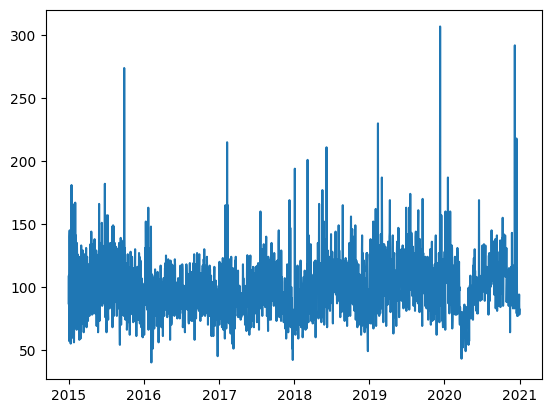

In [7]:
import matplotlib.pyplot as plt

time_counts = time_counts.set_index(time_counts['date'])
plt.plot(time_counts['dcount'])
plt.show()